<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture by Dr. Adrian Oeftiger</h2>

<img src="./img/etit.png" style="width: 20%; margin: auto;" />

<h3 style="text-align: center; vertical-align: middle;">Part 5: 25.11.2022</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-05/v0.1"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-05/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-05).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt, plot_rfwave, #RFBucket, 
                    plot_hamiltonian, plot_force, plot_potential)
from scipy.constants import m_p, e, c
%matplotlib inline

<h2 style="color: #b51f2a">Refresher!</h2>

- electric field in longitudinal direction, $E_z$: only way to accelerate
- transit-time factor
- energy gain in rf cavity: synchronous particle and real particles
- synchronicity in synchrotron: beam rigidity $B\rho=p/|q|$ and $f_\text{rf}=h\cdot f_\text{rev}$
- momentum compaction $\alpha_c=\cfrac{\Delta C/C}{\delta}$, phase slippage $\eta=\cfrac{\Delta T_\text{rev}/T_\text{rev}}{\delta}$ and transition energy $\gamma_\text{t}$
- phase focusing and stability
- longitudinal tracking equations

<h2 style="color: #b51f2a">Today!</h2>

1. Monte Carlo Technique & Pseudo-random Number Generation
2. Hamiltonian for Longitudinal Dynamics
3. Initialisation of Phase Space for Longitudinal Simulations

<div style="text-align: center; width:100%;">
    <h2>Part I: Monte Carlo</h2>
</div>

<h2>Monte Carlo Technique</h2>

1. Define a domain of possible inputs and identify the <b>statistical probability distribution</b> of these inputs.
2. Generate possible inputs through <b>random sampling</b> from the probability distribution over the domain.
3. Perform <b>simulation</b> with these input parameters.
4. Collect results and <b>analyse statistically</b>.

<h2>Approach</h2>

<b>Macro-particle simulation</b>:
- represent $10^{11}..10^{13}$ particles in a bunch by smooth particle distribution function $\psi(z,\delta)$
- generate distribution of $10^5..10^7$ macro-particles by randomly sampling $\psi(z,\delta)$

<b>Approach</b>:
- uniformly distributed (pseudo-)random numbers $\xi$: Linear Congruential Generators
- construct e.g. Gaussian normal distributed random numbers: Box-Muller method
- rejection technique

<h2>Generation of Uniformly Distributed Pseudo-random Numbers</h2>

<b>Linear Congruential Generator</b>:

starting from random number seed $x_0$, generate pseudo-random sequence for integer variable $x$:

$$x_{k+1} = (a\cdot x_k + c)\quad\%\quad M$$

where parameters $(a,c)$ and $M=2^m-1$ define the generator. $x$ lies on interval $[0,M)$ and attains at most $M$ values before reaching the same value.

E.g. typical choice (Lewis, Goodman, and Miller in 1969):

$$\left\{\begin{array}\,
    M &= 2^{31}-1 = 2147483647 \\
    a &= 7^5 = 16807 \\
    c &= 0
\end{array}\right.$$

A pseudo-random number distributed uniformly on interval $[0,1)$ is then obtained via

$$\xi = \frac{x}{M}$$

In [2]:
class RandomNumberGenerator(object):
    def __init__(self, M, a, c, seed):
        self.M = M
        self.a = a
        self.c = c
        self.M = M
        self.xk = seed

    def generate(self):
        xk1 = (self.a * self.xk + self.c) % self.M
        self.xk = xk1
        return xk1 / self.M

Instantiate the linear congruential generator by Lewis et al with a certain `seed`:

In [3]:
prng_standard = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=12345)

Generate a set of numbers from the sequence and analyse:

In [4]:
results = [prng_standard.generate() for i in range(10000)]

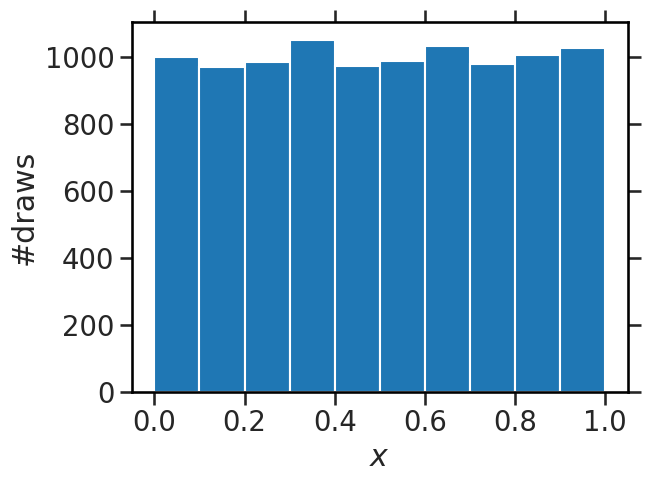

In [5]:
plt.hist(results)
plt.xlabel('$x$')
plt.ylabel('#draws');

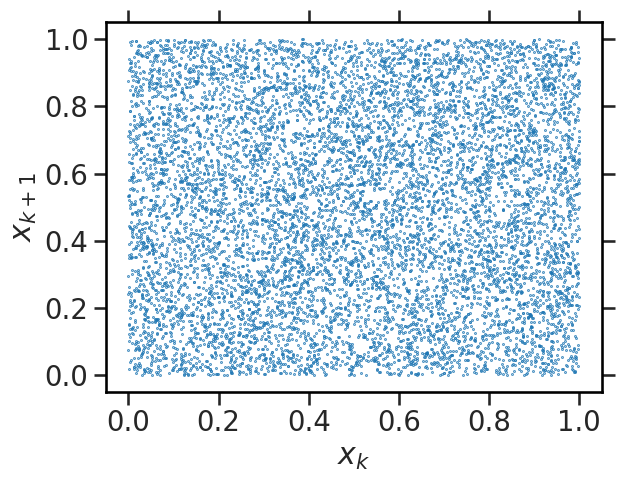

In [6]:
plt.scatter(results[:-1], results[1:], s=1, marker='.')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$');

<p style="color:red;">$\implies$ what happens if you change the parameters $M,a,c$?<br /><br />
Try e.g. $a=5$ or $M=2^{31}-2$...</p>

<h2>Generation of Gaussian Normal Distributed Pseudo-random Numbers</h2>

<b>Box-Muller Method</b>: Generate $x,y$ with bi-variate Gaussian normal probability density function $f(x,y)=\frac{1}{2\pi}e^{\frac{1}{2}\left(x^2 + y^2\right)}$ from uniformly distributed random numbers $\xi_1,\xi_2\in[0,1)$,

$$\begin{align}
    x &= \sqrt{-2\ln(\xi_2)}\,\cos(2\pi\xi_1) \\
    y &= \sqrt{-2\ln(\xi_2)}\,\sin(2\pi\xi_1)
\end{align}$$

which can be derived by <b>direct inversion</b> of the cumulative distribution function of $f$.

In [7]:
prng_1 = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=12345)

prng_2 = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=42)

In [8]:
def generate_normal():
    xi1 = prng_1.generate()
    xi2 = prng_1.generate()
    r = np.sqrt(-2 * np.log(xi2))
    x = r * np.cos(2 * np.pi * xi1)
    y = r * np.sin(2 * np.pi * xi1)
    return x, y

In [9]:
results = np.array(
    [generate_normal() for i in range(10000)]
).flatten()

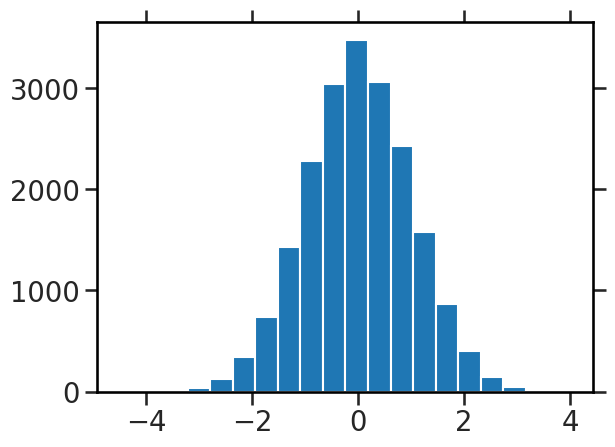

In [10]:
plt.hist(results, bins=20);


<h2>NumPy has it all...</h2>

The `numpy` library implements all of these (based on a better behaved variant of the linear congruential generator):

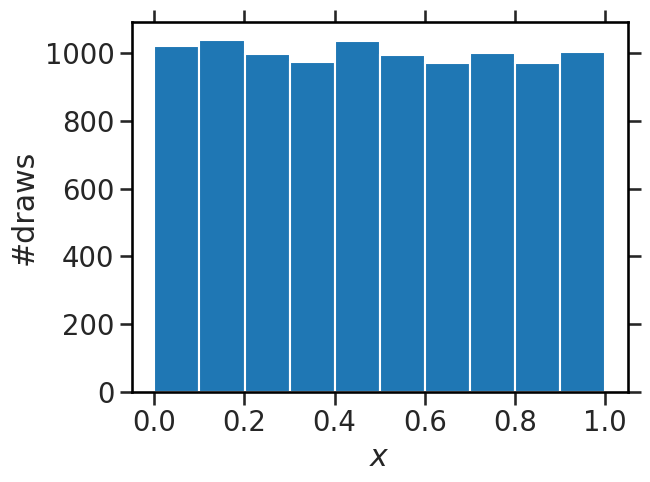

In [11]:
plt.hist(np.random.random(size=10000));
plt.xlabel('$x$')
plt.ylabel('#draws');

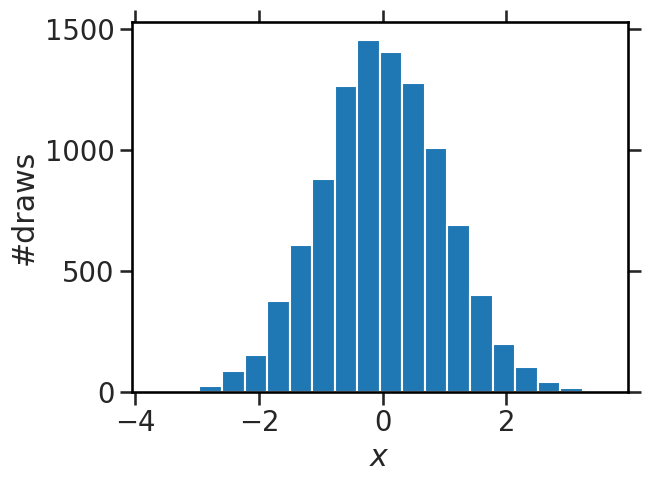

In [12]:
plt.hist(np.random.normal(size=10000), bins=20);
plt.xlabel('$x$')
plt.ylabel('#draws');

<div style="text-align: center; width:100%;">
    <h2>Part II: Hamiltonian for Longitudinal Dynamics</h2>
</div>

check back later for `v1.0`!

<div style="text-align: center; width:100%;">
    <h2>Part III: Initialisation of Phase Space for Longitudinal Simulations</h2>
</div>

check back later for `v1.0`!